In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.metrics import Precision
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import schedules
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.16.1
Num GPUs Available:  0


In [ ]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('2_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./data/2_150x9/')

file.close()

In [2]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/2_150x9/2_150x9f.csv'
    file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [3]:
# fit lstm model
from tabnanny import verbose

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model, learning_rate):
    LstmLayer = LSTM(
    units=neurons,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True, # true if cuDNN
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=dropout, # !important parameter for optimization => 0 if cuDNN
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False, # false if cuDNN
    input_shape=(x_train.shape[1],x_train.shape[2]),
    # input_dim=(x_train.shape[1])
    ) 

    if model == 0:
        model = Sequential() # initializing model
        # input layer and LSTM layer with 50 neurons
        model.add(LstmLayer)
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # outpute layer with sigmoid activation
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    if model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 3:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    lr_schedule = schedules.InverseTimeDecay(
    # lr_schedule = schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=80,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        # return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['precision'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        model.shuffle_weights(model, weights=None)
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping], verbose=2) # type: ignore
    return model, history

In [10]:
# Profit old
def funcProfitOld(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price', 'Open', 'High', 'Low'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Sell'] - df.at[i-1,'Sell']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum


# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

In [11]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, model, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    profitOld = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
        profitOld.append(funcProfitOld(predict, Y_test))
    
    return accuracy, profit, profitOld, metrics

In [12]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Precision', 'Loss'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['precision'], name=f'precision{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_precision'], name=f'val_precision{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")
    fig.show()

In [13]:
# Run
from numpy import dtype

repeats = 1
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
results_profitOld = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
features = 0
model = 0 # [0, 1, 2]
dropout = [0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 1

# Data gen
x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for dr in dropout:
 print(f"{dr} Model test start...")
 
 results_acc[str(dr)], results_profit[str(dr)], results_profitOld[str(dr)], metrics = experiment(
                                                                                            runMeter, 
                                                                                            repeats, 
                                                                                            epochs, 
                                                                                            neuronsLstm, 
                                                                                            timeStep, 
                                                                                            denseType, 
                                                                                            dr, 
                                                                                            model, 
                                                                                            features, 
                                                                                            learning_rate
                                                                                            )
                          
#  runMeter += 1
 plotsOut(dr, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())
print(results_profitOld.describe())

In [ ]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

             0.2        0.4        0.6        0.8
count   1.000000   1.000000   1.000000   1.000000
mean   68.887407  67.899603  68.166775  68.154955
std          NaN        NaN        NaN        NaN
min    68.887407  67.899603  68.166775  68.154955
25%    68.887407  67.899603  68.166775  68.154955
50%    68.887407  67.899603  68.166775  68.154955
75%    68.887407  67.899603  68.166775  68.154955
max    68.887407  67.899603  68.166775  68.154955
        0.2   0.4   0.6   0.8
count  1.00  1.00  1.00  1.00
mean  -0.01  1.65 -0.41 -0.96
std     NaN   NaN   NaN   NaN
min   -0.01  1.65 -0.41 -0.96
25%   -0.01  1.65 -0.41 -0.96
50%   -0.01  1.65 -0.41 -0.96
75%   -0.01  1.65 -0.41 -0.96
max   -0.01  1.65 -0.41 -0.96


             0.2        0.4        0.6        0.8
count   1.000000   1.000000   1.000000   1.000000
mean   68.887407  67.899603  68.166775  68.154955
std          NaN        NaN        NaN        NaN
min    68.887407  67.899603  68.166775  68.154955
25%    68.887407  67.899603  68.166775  68.154955
50%    68.887407  67.899603  68.166775  68.154955
75%    68.887407  67.899603  68.166775  68.154955
max    68.887407  67.899603  68.166775  68.154955


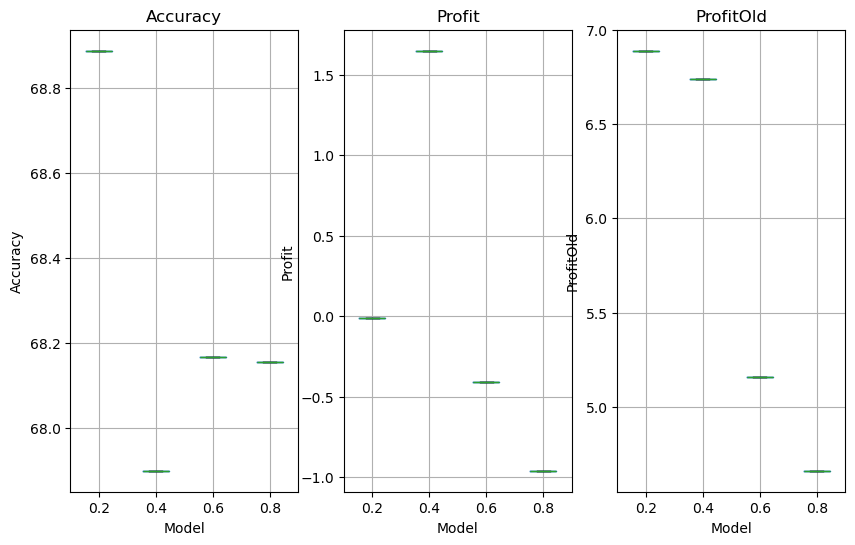

In [ ]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])
results_profitOld.boxplot(ax=ax[2])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')
ax[2].set_title('ProfitOld')
ax[2].set_xlabel('Model')
ax[2].set_ylabel('ProfitOld')

# Save to .png and show plot
plt.savefig(f'boxplot_dropout.png')
plt.show()